# Distance permutation analysis

In [1]:
# execute Setup.py
%run /Users/timnoahkempchen/Desktop/SAP5/src/Setup.py

In [2]:
sys.path.append(custom_functions_path) # This code is only needed if you want to load functions from a non-default directory

from helperfunctions_hf import * # Helper functions - used by other functions to execute steps like table formatting etc. KEY: hf
from preprocessing_pp import * # Preprocessing functions - to normalize and prepare data for further analysis KEY: pp
from tools_tl import * # tools - perform calculation on the data KEY: tl
from plot_pl import * # plotting functions - used to visualize results KEY: pl

In [3]:
# Load data
adata = ad.read_h5ad(adata_path + "adata_HuBMAP_subset_with_celltype.h5ad")

/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
df = pd.DataFrame(adata.obs)
df.head()

,x,y,array,Xcorr,Ycorr,Tissue_location,tissue,donor,unique_region,region,OLFM4,FAP,CD25,CollIV,CK7,MUC6,Cell Type
0,3651,7999,B005_SB,13059,7999,Duodenum,SB,B005,B005_Duodenum,2,0.329725,-0.518711,2.173225,0.217269,-0.305038,NaN,NK
1,1493,1656,B004_SB,1493,1656,Duodenum,SB,B004,B004_Duodenum,1,NaN,NaN,NaN,NaN,1.604023,NaN,NK
2,3487,7315,B004_SB,3487,7315,Duodenum,SB,B004,B004_Duodenum,1,NaN,NaN,NaN,NaN,2.794462,NaN,NK
3,3597,7314,B004_SB,3597,7314,Duodenum,SB,B004,B004_Duodenum,1,NaN,NaN,NaN,NaN,-0.133265,NaN,NK
4,2140,680,B004_SB,2140,680,Duodenum,SB,B004,B004_Duodenum,1,NaN,NaN,NaN,NaN,-0.133266,NaN,NK


In [5]:
# subset df for metadata
metadata = df[["donor", "tissue", "region", "unique_region"]]
metadata.head()

,donor,tissue,region,unique_region
0,B005,SB,2,B005_Duodenum
1,B004,SB,1,B004_Duodenum
2,B004,SB,1,B004_Duodenum
3,B004,SB,1,B004_Duodenum
4,B004,SB,1,B004_Duodenum


In [6]:
df["index"] = df.index

In [7]:
triangulation_distances = get_triangulation_distances(df_input = df, 
                                                      id = "index", 
                                                      x_pos = "x", 
                                                      y_pos = "y", 
                                                      cell_type = "Cell Type", 
                                                      region = "unique_region", 
                                                      num_cores=10)

In [8]:
iterative_triangulation_distances = iterate_triangulation_distances(df_input=df, 
                                                                    num_iterations=2, 
                                                                    id='index', 
                                                                    x_pos='x', 
                                                                    y_pos='y', 
                                                                    cell_type='Cell Type', 
                                                                    region='unique_region',
                                                                    num_cores = 10)

/Users/timnoahkempchen/Desktop/SAP5/src/tools_tl.py:1878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['uniqueID'] = subset[id].astype(str) + "-" + subset[x_pos].astype(str) + "-" + subset[y_pos].astype(str)
/Users/timnoahkempchen/Desktop/SAP5/src/tools_tl.py:1879: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['XYcellID'] = subset[x_pos].astype(str) + "_" + subset[y_pos].astype(str)
/Users/timnoahkempchen/Desktop/SAP5/src/tools_tl.py:1878: SettingWithCopyWarning: 
A value is trying to be set 

In [10]:
distance_pvals = identify_potential_interactions(triangulation_distances, 
                                                 iterative_triangulation_distances, 
                                                 metadata, 
                                                 min_observed = 10, 
                                                 distance_threshold = 128, 
                                                 comparison = 'tissue')

In [11]:
# calculate absolute logfold difference
distance_pvals['logfold_group_abs'] = distance_pvals['logfold_group'].abs()

# Filter significant p-values and other specified conditions
distance_pvals_sig = distance_pvals[
    (distance_pvals['pvalue'] < 0.05) &
    (distance_pvals['celltype1'] != distance_pvals['celltype2']) &
    (~distance_pvals['observed_mean'].isna()) &
    (distance_pvals['celltype1'] != "unknown") &
    (distance_pvals['celltype2'] != "unknown") &
    (distance_pvals['celltype1'] != "Noise") &
    (distance_pvals['celltype2'] != "Noise") &
    (distance_pvals['logfold_group_abs'] > 0.8) 
]

In [12]:
# Assuming distance_pvals_interesting2 is a pandas DataFrame with the same structure as the R dataframe.
pair_to = distance_pvals_sig['interaction'].unique()

# Filtering data
data = distance_pvals[~distance_pvals['interaction'].isna()]

# Creating pairs
data['pairs'] = data['celltype1'] + "_" + data['celltype2']

# Subsetting data
distance_pvals_sub = data[data['interaction'].isin(pair_to)]

In [14]:
distance_pvals_sub_reduced = distance_pvals_sub[['tissue', 'logfold_group', 'pairs']]
# set pairs as index
distance_pvals_sub_reduced = distance_pvals_sub_reduced.set_index('pairs')
# sort logfold_group into two columns by tissue
distance_pvals_sub_reduced = distance_pvals_sub_reduced.pivot(columns='tissue', values='logfold_group')

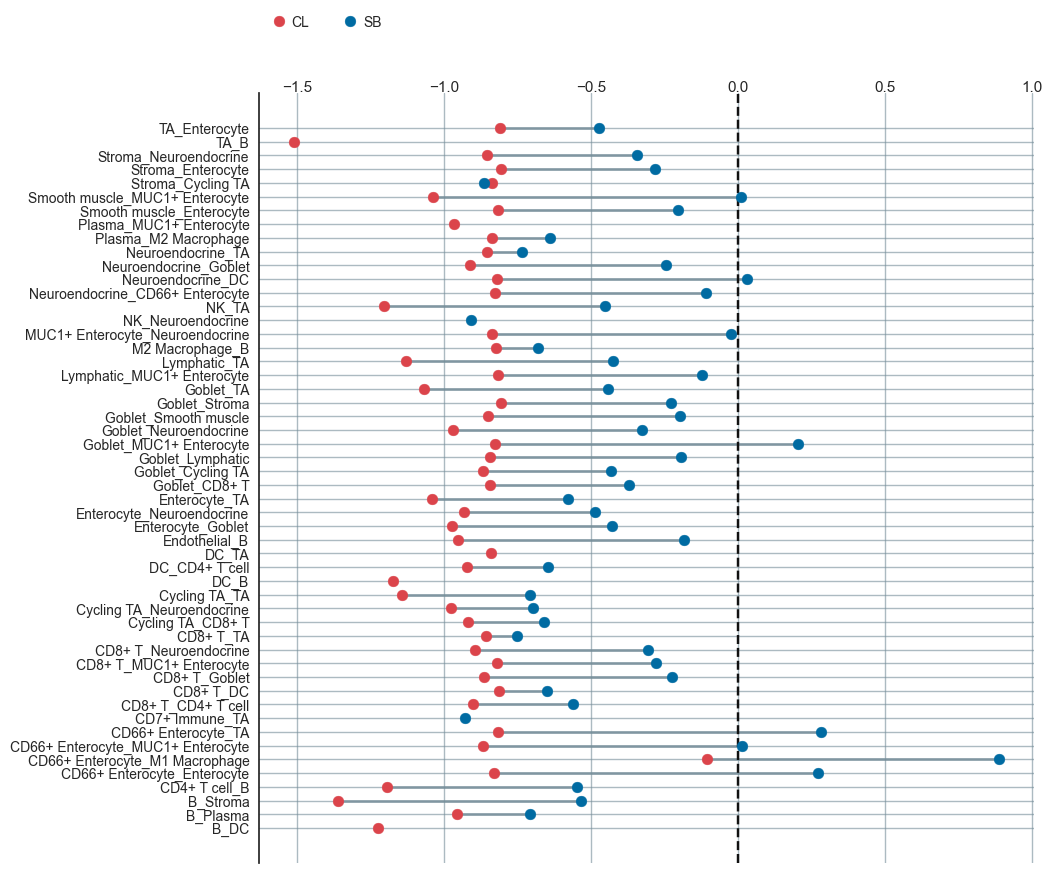

In [28]:
pl_dumbbell(data = distance_pvals_sub_reduced, figsize=(10,10), colors = ['#DB444B', '#006BA2'])